# English Wikipedia Page Views 

**The purpose of this notebook is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through September 30 2018. The plot created at the end is a reproduction of the English Wikipedia Page Views graph, originally created by Rex Thompson. **

In [24]:
# Import libraries
import json
import requests
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

%matplotlib inline

# To suppress warnings
pd.options.mode.chained_assignment = None

### Get the Wikipedia data

The data is sourced from two APIs:  
1) **The Legacy Pagecounts API** provides access to desktop and mobile traffic data from December 2007 through July 2016. This includes user as well as web crawler traffic.  
See: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end  

2) **The Pageviews API** provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month. This data will be filtered for user traffic using the agent=user filter as we want to focus on only organic traffic.  
See: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

#### Specify the endpoints

In [2]:
# Specify the endpoints of the two APIs
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#### Specify the parameters

In [3]:
# Legacy Pagecounts API

# parameters for getting aggregated legacy view data for desktop
desktop_params_legacy = {"project" : "en.wikipedia.org",
                         "access-site" : "desktop-site",
                         "granularity" : "monthly",
                         "start" : "2001010100",
                         # for end use 1st day of month following final month of data
                         "end" : "2018100100"
                        }

# parameters for getting aggregated legacy view data for mobile
mobile_params_legacy = {"project" : "en.wikipedia.org",
                         "access-site" : "mobile-site",
                         "granularity" : "monthly",
                         "start" : "2001010100",
                         # for end use 1st day of month following final month of data
                         "end" : "2018100100"
                        }


# Current Pageviews API
# parameters for getting aggregated current standard pageview data for desktop

desktop_params_pageviews = {"project" : "en.wikipedia.org",
                            "access" : "desktop",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2001010100",
                            # for end use 1st day of month following final month of data
                            "end" : '2018101000'
                            }

# parameters for getting aggregated current standard pageview data for mobile-app
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                               "access" : "mobile-app",
                               "agent" : "user",
                               "granularity" : "monthly",
                               "start" : "2001010100",
                               # for end use 1st day of month following final month of data
                               "end" : '2018101000'
                              }

# parameters for getting aggregated current standard pageview data for mobile-web
mobile_web_params_pageviews = {"project" : "en.wikipedia.org",
                              "access" : "mobile-web",
                              "agent" : "user",
                              "granularity" : "monthly",
                              "start" : "2001010100",
                              # for end use 1st day of month following final month of data
                              "end" : '2018101000'
                              }

# Customize these with your own information
headers = {
            'User-Agent': 'https://github.com/priyankam22',
            'From': 'mhatrep@uw.edu'
          }

#### Make calls to the API to get data

In [6]:
# A function to make requests to the API for data
def api_call(endpoint, parameters, headers):
    '''
    This function makes a call to the API endpoint and returns a Python dictionary.
    
    Inputs:
    endpoint - the endpoint of the API to be called
    parameters -  parameters that can be passed to the API
    headers - some header information which specifies identity of the caller
    
    Outputs:
    reponse - python dictionary of data returned by API
    '''
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [7]:
# Get the legacy data from the Pagecounts API
desktop_monthly_legacy = api_call(endpoint_legacy, desktop_params_legacy, headers)
mobile_monthly_legacy = api_call(endpoint_legacy, mobile_params_legacy, headers)

# Get current data from the Pageviews API
desktop_monthly_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews, headers)
mobile_app_monthly_pageviews = api_call(endpoint_pageviews, mobile_app_params_pageviews, headers)
mobile_web_monthly_pageviews = api_call(endpoint_pageviews, mobile_web_params_pageviews, headers)

The below two steps are for reproducibility and can be skipped if you are pulling the data from the APIs.

In [11]:
# Save the data in json files on disk, This step saves intermediate results which can be used for reproducibility in future.
with open('../data/pagecounts_desktop-site_200712-201809.json','w') as outfile:
    json.dump(desktop_monthly_legacy, outfile)
with open('../data/pagecounts_mobile-site_200712-201809.json','w') as outfile:
    json.dump(mobile_monthly_legacy, outfile)
with open('../data/pageviews_desktop_200712-201809.json','w') as outfile:
    json.dump(desktop_monthly_pageviews, outfile)
with open('../data/pageviews_mobile-app_200712-201809.json','w') as outfile:
    json.dump(mobile_app_monthly_pageviews, outfile)
with open('../data/pageviews_mobile-web_200712-201809.json','w') as outfile:
    json.dump(mobile_web_monthly_pageviews, outfile)

In [12]:
# Load the data from json files if these files are available.
with open('../data/pagecounts_desktop-site_200712-201809.json') as infile:
    desktop_monthly_legacy = json.load(infile)
with open('../data/pagecounts_mobile-site_200712-201809.json') as infile:
    mobile_monthly_legacy = json.load(infile)
with open('../data/pageviews_desktop_200712-201809.json') as infile:
    desktop_monthly_pageviews = json.load(infile)
with open('../data/pageviews_mobile-app_200712-201809.json') as infile:
    mobile_app_monthly_pageviews = json.load(infile)
with open('../data/pagecounts_mobile-web_200712-201809.json') as infile:
    mobile_web_monthly_pageviews = json.load(infile)

### Data Processing

In [13]:
# Load the dict data into Pandas dataframes for easy manipulation
desktop_monthly_pagecounts_df = pd.DataFrame(desktop_monthly_legacy['items'])
mobile_monthly_pagecounts_df = pd.DataFrame(mobile_monthly_legacy['items'])

desktop_monthly_pageviews_df = pd.DataFrame(desktop_monthly_pageviews['items'])
mobile_app_monthly_pageviews_df = pd.DataFrame(mobile_app_monthly_pageviews['items'])
mobile_web_monthly_pageviews_df = pd.DataFrame(mobile_web_monthly_pageviews['items'])

In [14]:
# Add the mobile app and mobile web data for Pageviews as we are interested in the total mobile views 
mobile_monthly_pageviews_df = mobile_app_monthly_pageviews_df.merge(mobile_web_monthly_pageviews_df, on='timestamp')
mobile_monthly_pageviews_df['pageview_mobile_views'] = mobile_monthly_pageviews_df['views_x'] + mobile_monthly_pageviews_df['views_y']

In [16]:
mobile_monthly_pageviews_df[['timestamp','pageview_mobile_views']][0:10]

,timestamp,pageview_mobile_views
0,2015070100,3288755294
1,2015080100,3302333038
2,2015090100,3170203333
3,2015100100,3268499132
4,2015110100,3236601070
5,2015120100,3376275307
6,2016010100,3717836846
7,2016020100,3334862272
8,2016030100,3386684191
9,2016040100,3258764002


#### Merge the 4 dataframes on timestamp

In [17]:
# Renaming the views columns for merging
desktop_monthly_pageviews_df.rename(columns={'views': 'pageview_desktop_views'}, inplace=True)
desktop_monthly_pagecounts_df.rename(columns={'count': 'pagecount_desktop_views'}, inplace=True)
mobile_monthly_pagecounts_df.rename(columns={'count': 'pagecount_mobile_views'}, inplace=True)

# Select the relevant columns for merging
dfs = [ desktop_monthly_pagecounts_df[['timestamp','pagecount_desktop_views']],
        mobile_monthly_pagecounts_df[['timestamp','pagecount_mobile_views']],
        desktop_monthly_pageviews_df[['timestamp','pageview_desktop_views']],
        mobile_monthly_pageviews_df[['timestamp','pageview_mobile_views']]
      ]

# Merge the dataframes on timestamp
dataset = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='outer'), dfs)

In [ ]:
# Replace nans with 0
dataset.fillna(0, inplace=True)

# Create the total views for each API
dataset['pagecount_all_views'] = dataset['pagecount_desktop_views'] + dataset['pagecount_mobile_views']
dataset['pageview_all_views'] = dataset['pageview_desktop_views'] + dataset['pageview_mobile_views']

# Extract the year and month from timestamp
dataset['year'] = dataset['timestamp'].apply(lambda x: x[:4])
dataset['month'] = dataset['timestamp'].apply(lambda x: x[4:6])
dataset.drop(['timestamp'], axis=1, inplace=True)

# Rearranging the columns
dataset = dataset[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

# Write the resulting dataframe to csv
dataset.to_csv('../data/en-wikipedia_traffic_200712-201809.csv')

### Plot the Pageviews as a time series

In [22]:
# Divide all the view counts by 1000000 for better readability of the plots
dataset['pagecount_desktop_views'] = dataset['pagecount_desktop_views'].apply(lambda x: x/10**6)
dataset['pagecount_mobile_views'] = dataset['pagecount_mobile_views'].apply(lambda x: x/10**6)
dataset['pageview_desktop_views'] = dataset['pageview_desktop_views'].apply(lambda x: x/10**6)
dataset['pageview_mobile_views'] = dataset['pageview_mobile_views'].apply(lambda x: x/10**6)
dataset['pagecount_all_views'] = dataset['pagecount_all_views'].apply(lambda x: x/10**6)
dataset['pageview_all_views'] = dataset['pageview_all_views'].apply(lambda x: x/10**6)

# Combine the year and month for xaxis
dataset['timestamp'] = dataset['year']+dataset['month']

In [26]:
# Set the Aug 2016 values for legacy columns to zero as the data collection looks incomplete in that month
# The legacy system seems to be discontinued after 201608. 
mask = (dataset['year'] == '2016') & (dataset['month'] == '08')
dataset.loc[mask, 'pagecount_all_views'] = np.nan
dataset.loc[mask, 'pagecount_desktop_views'] = np.nan
dataset.loc[mask, 'pagecount_mobile_views'] = np.nan

# Replace 0 with nan so that it is not plotted on the graph
dataset.replace(0,np.nan, inplace=True)

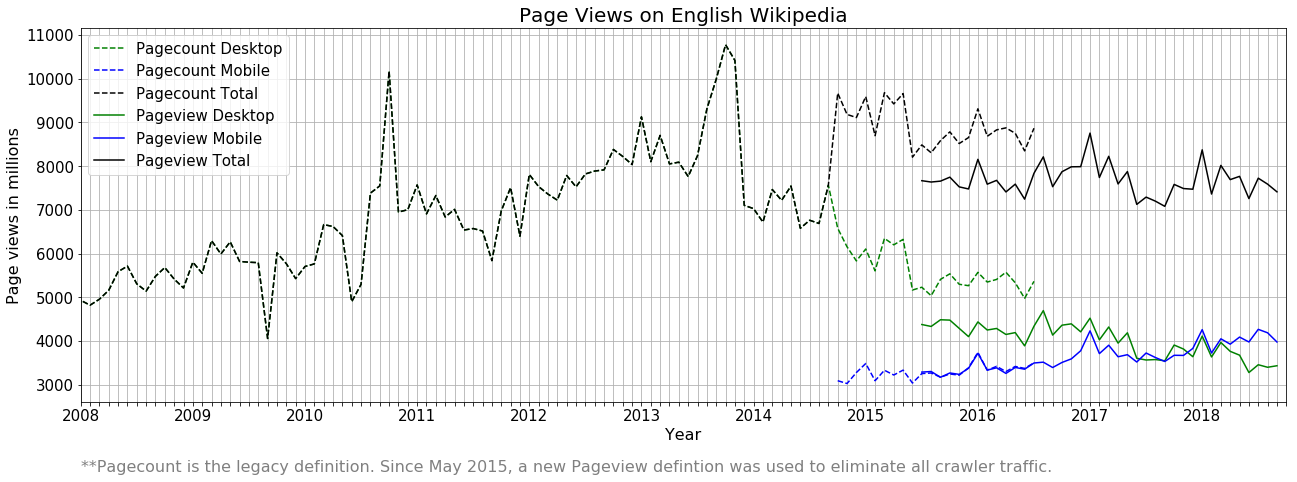

In [27]:
# Set default fintsize for the plot
plt.rcParams.update({'font.size': 15})

# Add lines for all the different columns in the dataset
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(dataset['timestamp'], dataset['pagecount_desktop_views'],'g--', label='Pagecount Desktop')
plt.plot(dataset['timestamp'], dataset['pagecount_mobile_views'],'b--', label='Pagecount Mobile')
plt.plot(dataset['timestamp'], dataset['pagecount_all_views'],'k--', label='Pagecount Total')
plt.plot(dataset['timestamp'], dataset['pageview_desktop_views'],'g', label='Pageview Desktop')
plt.plot(dataset['timestamp'], dataset['pageview_mobile_views'],'b', label='Pageview Mobile')
plt.plot(dataset['timestamp'], dataset['pageview_all_views'],'k', label='Pageview Total')

# Limit the xaxis
plt.xlim('200801','201812')

# Limit the xaxis labels to first month of each year and reformat to year
plt.draw()
labels = [l.get_text()[:4] if l.get_text()[-2:] == '01' else '' for l in ax.get_xticklabels() ]
ax.set_xticklabels(labels)

plt.legend(loc='upper left')
plt.tight_layout()

plt.title("Page Views on English Wikipedia", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Page views in millions", fontsize=16)
plt.tick_params(labelsize=15)
plt.grid()
plt.annotate('**Pagecount is the legacy definition. Since May 2015, a new Pageview defintion was used to eliminate all crawler traffic. ', 
             (0,0),(0, -70),  xycoords='axes fraction', textcoords='offset points',color='gray', size=16 )
plt.show()

In [32]:
# Save file to plot folder
fig.savefig('English Wikipedia PageViews Graph.jpeg', format='jpeg')